# Overview of this jupyter notebook

1. Loading the data
2. Hyperparameter optimization for randomforest model
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from skmultilearn.problem_transform import BinaryRelevance
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')
import pickle
import json
import random

In [2]:
import os
import importlib
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [3]:
!python -V

Python 3.10.6


# 1. Loading the data

In [5]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [6]:
feature_train = pd.read_pickle("feature_label/mlc_feature_train_tsfresh_2.4.pkl")
feature_train.shape

(1550, 789)

In [7]:
feature_test = pd.read_pickle("feature_label/mlc_feature_test_tsfresh_2.4.pkl")
feature_test.shape

(750, 789)

In [8]:
label_train = pd.read_pickle("feature_label/mlc_label_train_tsfresh_v2.4.pkl")
label_train.shape

(1550, 8)

In [9]:
label_test = pd.read_pickle("feature_label/mlc_label_test_tsfresh_v2.4.pkl")
label_test.shape

(750, 8)

In [10]:
# relevance table has the information about which feature is relevant for the classification task based on p-value

relevance_table = pd.read_pickle("feature_label/mlc_relevance_table_tsfresh_v2.4.pkl")
relevance_table = relevance_table[relevance_table.relevant==True]
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"torque__fft_coefficient__attr_""imag""__coeff_92","torque__fft_coefficient__attr_""imag""__coeff_92",real,9.478897e-01,False,1.716470e-01,False,9.849157e-01,False,1.072699e-04,True,8.559883e-01,False,5.015247e-01,False,1.822312e-01,False,4.250886e-01,False,4.911643e-01,False,1.170838e-02,False,1.711853e-01,False,8.991722e-01,False,0.025441,False,7.237413e-01,False,0.292634,False,1,True
"torque__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)",torque__cwt_coefficients__coeff_12__w_2__width...,real,9.544628e-01,False,2.995364e-12,True,1.424985e-01,False,3.158056e-02,False,4.182010e-03,False,5.572269e-01,False,1.291619e-01,False,2.636988e-01,False,2.499537e-07,True,2.074936e-01,False,6.579449e-01,False,8.661737e-02,False,0.083162,False,6.838159e-01,False,0.142855,False,2,True
"torque__fft_coefficient__attr_""real""__coeff_91","torque__fft_coefficient__attr_""real""__coeff_91",real,9.748111e-01,False,1.528592e-01,False,9.135638e-01,False,2.650780e-05,True,9.138683e-01,False,6.113325e-01,False,5.596143e-01,False,2.779372e-01,False,4.141510e-01,False,1.277503e-02,False,1.527884e-01,False,7.170111e-01,False,0.003934,False,5.555035e-01,False,0.163287,False,1,True


In [13]:
relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

615

In [14]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((1550, 615), (750, 615))

In [15]:
lab_train = label_train.values
lab_test = label_test.values
lab_train.shape, lab_test.shape

((1550, 8), (750, 8))

In [16]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train, lab_train, random_state=9)
x_test, y_test = shuffle(feat_test, lab_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1550, 615), (1550, 8), (750, 615), (750, 8))

In [18]:
x_train

,torque__ratio_value_number_to_time_series_length,torque__approximate_entropy__m_2__r_0.7,torque__symmetry_looking__r_0.05,torque__quantile__q_0.9,torque__approximate_entropy__m_2__r_0.5,"torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6",torque__count_below_mean,torque__count_above_mean,"torque__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",torque__skewness,"torque__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6",torque__ratio_beyond_r_sigma__r_0.5,"torque__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",torque__ratio_beyond_r_sigma__r_1,"torque__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","torque__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","torque__agg_autocorrelation__f_agg_""mean""__maxlag_40",torque__approximate_entropy__m_2__r_0.9,"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",torque__mean,torque__sum_values,"torque__fft_coefficient__attr_""abs""__coeff_93","torque__fft_coefficient__attr_""imag""__coeff_2","torque__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","torque__agg_autocorrelation__f_agg_""median""__maxlag_40","torque__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.6",...,"torque__fft_coefficient__attr_""real""__coeff_33","torque__fft_coefficient__attr_""imag""__coeff_57","torque__fft_coefficient__attr_""angle""__coeff_41","torque__fft_coefficient__attr_""real""__coeff_68","torque__fft_coefficient__attr_""real""__coeff_32","torque__fft_coefficient__attr_""angle""__coeff_43","torque__fft_coefficient__attr_""imag""__coeff_97","torque__fft_coefficient__attr_""imag""__coeff_88","torque__fft_coefficient__attr_""real""__coeff_36","torque__fft_coefficient__attr_""imag""__coeff_31","torque__fft_coefficient__attr_""imag""__coeff_40","torque__fft_coefficient__attr_""angle""__coeff_74","torque__fft_coefficient__attr_""real""__coeff_61","torque__fft_coefficient__attr_""real""__coeff_38","torque__fft_coefficient__attr_""real""__coeff_51","torque__fft_coefficient__attr_""real""__coeff_62","torque__fft_coefficient__attr_""imag""__coeff_58","torque__fft_coefficient__attr_""real""__coeff_76","torque__fft_coefficient__attr_""imag""__coeff_52","torque__fft_coefficient__attr_""imag""__coeff_62","torque__fft_coefficient__attr_""real""__coeff_59","torque__fft_coefficient__attr_""imag""__coeff_53","torque__fft_coefficient__attr_""imag""__coeff_50","torque__fft_coefficient__attr_""angle""__coeff_94","torque__fft_coefficient__attr_""real""__coeff_70","torque__fft_coefficient__attr_""real""__coeff_55","torque__fft_coefficient__attr_""imag""__coeff_60",torque__large_standard_deviation__r_0.25,"torque__fft_coefficient__attr_""imag""__coeff_37",torque__symmetry_looking__r_0.15000000000000002
128,0.034783,0.015466,1.0,0.017920,0.015998,0.000009,0.000004,846.0,74.0,0.000007,0.000009,0.000009,4.623123,0.001493,0.078261,0.000013,0.077174,-3.514553,0.007621,0.593870,0.015959,62.41536,62.41536,0.067843,62.41536,4.243238,-3.822249,0.001958,0.586557,-0.000076,...,-6.625098,6.579156,-99.152194,-4.342443,9.588604,102.927961,-3.713665,3.008880,3.672719,-10.059087,2.417685,36.059257,-5.381523,0.627847,-5.495040,-3.916378,-2.948483,-3.438192,-4.975628,-5.832297,3.671495,2.913696,6.111008,-72.650971,5.704840,-1.223539,4.638807,0.0,1.017691,1.0
1635,0.113043,0.051706,1.0,0.322560,0.071933,0.000129,0.000102,580.0,340.0,0.000192,0.000120,0.000105,2.609210,0.009517,0.450000,0.000213,0.080435,-3.420009,0.010295,0.615047,0.037587,166.25280,166.25280,0.180710,166.25280,0.834460,15.004809,0.010386,0.576596,0.000278,...,-6.694362,-0.334720,-67.574423,-1.154582,-6.744774,19.136828,0.216556,-0.606185,1.074620,8.211804,2.458706,-40.192991,2.258181,-2.428887,-3.013001,-0.027897,-0.185941,-

In [19]:
x_test

,torque__ratio_value_number_to_time_series_length,torque__approximate_entropy__m_2__r_0.7,torque__symmetry_looking__r_0.05,torque__quantile__q_0.9,torque__approximate_entropy__m_2__r_0.5,"torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6",torque__count_below_mean,torque__count_above_mean,"torque__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",torque__skewness,"torque__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6",torque__ratio_beyond_r_sigma__r_0.5,"torque__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",torque__ratio_beyond_r_sigma__r_1,"torque__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","torque__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","torque__agg_autocorrelation__f_agg_""mean""__maxlag_40",torque__approximate_entropy__m_2__r_0.9,"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",torque__mean,torque__sum_values,"torque__fft_coefficient__attr_""abs""__coeff_93","torque__fft_coefficient__attr_""imag""__coeff_2","torque__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","torque__agg_autocorrelation__f_agg_""median""__maxlag_40","torque__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.6",...,"torque__fft_coefficient__attr_""real""__coeff_33","torque__fft_coefficient__attr_""imag""__coeff_57","torque__fft_coefficient__attr_""angle""__coeff_41","torque__fft_coefficient__attr_""real""__coeff_68","torque__fft_coefficient__attr_""real""__coeff_32","torque__fft_coefficient__attr_""angle""__coeff_43","torque__fft_coefficient__attr_""imag""__coeff_97","torque__fft_coefficient__attr_""imag""__coeff_88","torque__fft_coefficient__attr_""real""__coeff_36","torque__fft_coefficient__attr_""imag""__coeff_31","torque__fft_coefficient__attr_""imag""__coeff_40","torque__fft_coefficient__attr_""angle""__coeff_74","torque__fft_coefficient__attr_""real""__coeff_61","torque__fft_coefficient__attr_""real""__coeff_38","torque__fft_coefficient__attr_""real""__coeff_51","torque__fft_coefficient__attr_""real""__coeff_62","torque__fft_coefficient__attr_""imag""__coeff_58","torque__fft_coefficient__attr_""real""__coeff_76","torque__fft_coefficient__attr_""imag""__coeff_52","torque__fft_coefficient__attr_""imag""__coeff_62","torque__fft_coefficient__attr_""real""__coeff_59","torque__fft_coefficient__attr_""imag""__coeff_53","torque__fft_coefficient__attr_""imag""__coeff_50","torque__fft_coefficient__attr_""angle""__coeff_94","torque__fft_coefficient__attr_""real""__coeff_70","torque__fft_coefficient__attr_""real""__coeff_55","torque__fft_coefficient__attr_""imag""__coeff_60",torque__large_standard_deviation__r_0.25,"torque__fft_coefficient__attr_""imag""__coeff_37",torque__symmetry_looking__r_0.15000000000000002
1803,0.097826,0.043324,1.0,0.295680,0.066027,0.000100,0.000043,559.0,361.0,0.000103,0.000095,0.000054,3.723921,0.007760,0.367391,0.000122,0.076087,-3.078276,0.028203,0.623819,0.030814,172.06784,172.06784,0.187030,172.06784,3.499866,-10.627624,0.008289,0.616836,0.000661,...,-4.114237,1.551965,143.281907,2.266371,9.462157,-28.356569,-0.284365,5.404213,7.310518,-8.125803,3.312605,-96.271210,-6.256304,-5.844302,3.296478,-2.718612,-6.624126,1.010527,3.349465,-5.998329,6.758372,4.347983,-3.536948,-80.277109,0.050155,3.959029,7.150218,0.0,6.337831,1.0
1597,0.102174,0.041037,0.0,0.309120,0.042560,0.000067,0.000068,584.0,336.0,0.000147,0.000067,0.000053,3.503986,0.008985,0.660870,0.000098,0.079348,-2.767359,0.063090,0.677280,0.035267,131.93600,131.93600,0.143409,131.93600,4.331998,-24.290440,0.006705,0.676148,0.000916,...,0.522380,3.481790,-131.011609,1.257363,9.574800,60.363996,3.468525,-4.778185,4.374408,-9.783988,3.695826,-51.039982,3.073641,-2.274468,-2.114465,-5.965412,3.446420,-

# 2. Hyperparameter optimization for randomforest model

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
parameters = {'n_estimators':[50, 100, 200], 'criterion':['gini', 'entropy'],
              'min_samples_leaf': [1,4,8], 'min_samples_split': [2,4,8],
              'max_depth':[20,80,200], 'max_features':['sqrt', 'log2'],
              'min_impurity_decrease':[0.0, 0.0001, 0.001]}

search = GridSearchCV(RandomForestClassifier(), parameters, cv=5, verbose=10)
search.fit(x_train, y_train)
print(search.best_score_, search.best_params_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV 1/5; 1/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/5; 1/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.884 total time=   1.0s
[CV 2/5; 1/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/5; 1/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.858 total time=   0.9s
[CV 3/5; 1/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 3/5; 1/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min

[CV 5/5; 5/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.910 total time=   1.8s
[CV 1/5; 6/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 1/5; 6/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.897 total time=   3.7s
[CV 2/5; 6/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 2/5; 6/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.855 total time=   3.6s
[CV 3/5; 6/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_sampl

[CV 4/5; 10/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.871 total time=   0.8s
[CV 5/5; 10/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 5/5; 10/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.874 total time=   0.8s
[CV 1/5; 11/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 1/5; 11/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.874 total time=   1.6s
[CV 2/5; 11/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_sa

[CV 3/5; 15/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.894 total time=   3.4s
[CV 4/5; 15/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 4/5; 15/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.865 total time=   3.3s
[CV 5/5; 15/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 5/5; 15/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.887 total time=   3.3s
[CV 1/5; 16/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min

[CV 2/5; 20/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.823 total time=   1.5s
[CV 3/5; 20/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 3/5; 20/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.871 total time=   1.5s
[CV 4/5; 20/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 4/5; 20/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.861 total time=   1.4s
[CV 5/5; 20/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min

[CV 1/5; 25/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.852 total time=   0.7s
[CV 2/5; 25/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 2/5; 25/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.819 total time=   0.7s
[CV 3/5; 25/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 3/5; 25/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.865 total time=   0.7s
[CV 4/5; 25/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samp

[CV 5/5; 29/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.906 total time=   1.8s
[CV 1/5; 30/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/5; 30/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.897 total time=   3.7s
[CV 2/5; 30/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 2/5; 30/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.865 total time=   3.7s
[CV 3/5; 30/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_s

[CV 4/5; 34/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.887 total time=   0.8s
[CV 5/5; 34/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 5/5; 34/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.897 total time=   0.8s
[CV 1/5; 35/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 1/5; 35/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.897 total time=   1.7s
[CV 2/5; 35/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samp

[CV 3/5; 39/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.881 total time=   3.4s
[CV 4/5; 39/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 4/5; 39/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.877 total time=   3.3s
[CV 5/5; 39/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 5/5; 39/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.877 total time=   3.4s
[CV 1/5; 40/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_s

[CV 2/5; 44/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.858 total time=   1.6s
[CV 3/5; 44/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 3/5; 44/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.881 total time=   1.6s
[CV 4/5; 44/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 4/5; 44/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.877 total time=   1.7s
[CV 5/5; 44/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_s

[CV 1/5; 49/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.848 total time=   0.7s
[CV 2/5; 49/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 2/5; 49/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.826 total time=   0.8s
[CV 3/5; 49/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 3/5; 49/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.861 total time=   0.7s
[CV 4/5; 49/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_sample

[CV 5/5; 53/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.865 total time=   1.4s
[CV 1/5; 54/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 1/5; 54/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.852 total time=   3.0s
[CV 2/5; 54/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 2/5; 54/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.823 total time=   3.0s
[CV 3/5; 54/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_s

[CV 4/5; 58/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.874 total time=   0.8s
[CV 5/5; 58/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 5/5; 58/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.890 total time=   0.8s
[CV 1/5; 59/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 1/5; 59/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.861 total time=   1.7s
[CV 2/5; 59/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_le

[CV 3/5; 63/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.884 total time=   3.4s
[CV 4/5; 63/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 4/5; 63/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.871 total time=   3.3s
[CV 5/5; 63/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 5/5; 63/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.887 total time=   3.3s
[CV 1/5; 64/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples

[CV 2/5; 68/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.842 total time=   1.5s
[CV 3/5; 68/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 3/5; 68/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.881 total time=   1.5s
[CV 4/5; 68/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 4/5; 68/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.868 total time=   1.5s
[CV 5/5; 68/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples

[CV 1/5; 73/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.845 total time=   0.7s
[CV 2/5; 73/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 2/5; 73/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.826 total time=   0.7s
[CV 3/5; 73/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 3/5; 73/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.871 total time=   0.7s
[CV 4/5; 73/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf

[CV 5/5; 77/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.868 total time=   1.5s
[CV 1/5; 78/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 1/5; 78/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.829 total time=   3.0s
[CV 2/5; 78/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 2/5; 78/972] END criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.829 total time=   3.0s
[CV 3/5; 78/972] START criterion=gini, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples

[CV 4/5; 82/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.887 total time=   0.4s
[CV 5/5; 82/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 5/5; 82/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.881 total time=   0.4s
[CV 1/5; 83/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 83/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.887 total time=   0.8s
[CV 2/5; 83/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_sa

[CV 3/5; 87/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.881 total time=   1.7s
[CV 4/5; 87/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 4/5; 87/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.874 total time=   1.7s
[CV 5/5; 87/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 5/5; 87/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.887 total time=   1.7s
[CV 1/5; 88/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min

[CV 2/5; 92/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.823 total time=   0.7s
[CV 3/5; 92/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 3/5; 92/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.852 total time=   0.7s
[CV 4/5; 92/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 4/5; 92/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.868 total time=   0.7s
[CV 5/5; 92/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min

[CV 1/5; 97/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.874 total time=   0.3s
[CV 2/5; 97/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 2/5; 97/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.845 total time=   0.3s
[CV 3/5; 97/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 3/5; 97/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.865 total time=   0.3s
[CV 4/5; 97/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samp

[CV 5/5; 101/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.839 total time=   0.7s
[CV 1/5; 102/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 1/5; 102/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.826 total time=   1.4s
[CV 2/5; 102/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 2/5; 102/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.826 total time=   1.4s
[CV 3/5; 102/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=

[CV 4/5; 106/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.829 total time=   0.3s
[CV 5/5; 106/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 5/5; 106/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.826 total time=   0.3s
[CV 1/5; 107/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 1/5; 107/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.826 total time=   0.6s
[CV 2/5; 107/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, 

[CV 3/5; 111/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.894 total time=   1.7s
[CV 4/5; 111/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 4/5; 111/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.890 total time=   1.7s
[CV 5/5; 111/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 5/5; 111/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.897 total time=   1.7s
[CV 1/5; 112/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001,

[CV 2/5; 116/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.852 total time=   0.8s
[CV 3/5; 116/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 3/5; 116/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.874 total time=   0.8s
[CV 4/5; 116/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 4/5; 116/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.874 total time=   0.8s
[CV 5/5; 116/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001,

[CV 1/5; 121/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.852 total time=   0.3s
[CV 2/5; 121/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 2/5; 121/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.839 total time=   0.3s
[CV 3/5; 121/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 3/5; 121/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.861 total time=   0.3s
[CV 4/5; 121/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_

[CV 5/5; 125/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.861 total time=   0.7s
[CV 1/5; 126/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 1/5; 126/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.865 total time=   1.5s
[CV 2/5; 126/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 2/5; 126/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.848 total time=   1.5s
[CV 3/5; 126/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001,

[CV 4/5; 130/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.819 total time=   0.3s
[CV 5/5; 130/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 5/5; 130/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.832 total time=   0.3s
[CV 1/5; 131/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 1/5; 131/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.832 total time=   0.6s
[CV 2/5; 131/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, mi

[CV 3/5; 135/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.852 total time=   1.4s
[CV 4/5; 135/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 4/5; 135/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.826 total time=   1.4s
[CV 5/5; 135/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 5/5; 135/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.832 total time=   1.4s
[CV 1/5; 136/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, 

[CV 2/5; 140/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.852 total time=   0.7s
[CV 3/5; 140/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 3/5; 140/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.852 total time=   0.7s
[CV 4/5; 140/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 4/5; 140/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.855 total time=   0.7s
[CV 5/5; 140/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_s

[CV 1/5; 145/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.839 total time=   0.3s
[CV 2/5; 145/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 2/5; 145/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.835 total time=   0.3s
[CV 3/5; 145/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 3/5; 145/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.826 total time=   0.3s
[CV 4/5; 145/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_sample

[CV 5/5; 149/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.845 total time=   0.7s
[CV 1/5; 150/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 1/5; 150/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.826 total time=   1.6s
[CV 2/5; 150/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 2/5; 150/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.845 total time=   1.6s
[CV 3/5; 150/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_s

[CV 4/5; 154/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.829 total time=   0.3s
[CV 5/5; 154/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 5/5; 154/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.829 total time=   0.3s
[CV 1/5; 155/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 1/5; 155/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.803 total time=   0.6s
[CV 2/5; 155/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samp

[CV 3/5; 159/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.800 total time=   1.3s
[CV 4/5; 159/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 4/5; 159/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.819 total time=   1.3s
[CV 5/5; 159/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 5/5; 159/972] END criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.829 total time=   1.3s
[CV 1/5; 160/972] START criterion=gini, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_s

[CV 2/5; 164/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.881 total time=   1.8s
[CV 3/5; 164/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 164/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.890 total time=   1.8s
[CV 4/5; 164/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 164/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.881 total time=   1.8s
[CV 5/5; 164/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=

[CV 1/5; 169/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.887 total time=   0.8s
[CV 2/5; 169/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 2/5; 169/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.861 total time=   0.8s
[CV 3/5; 169/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 3/5; 169/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.903 total time=   0.8s
[CV 4/5; 169/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, mi

[CV 5/5; 173/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.897 total time=   1.6s
[CV 1/5; 174/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 1/5; 174/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.881 total time=   3.3s
[CV 2/5; 174/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 2/5; 174/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.855 total time=   3.3s
[CV 3/5; 174/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=

[CV 4/5; 178/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.877 total time=   0.8s
[CV 5/5; 178/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 5/5; 178/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.881 total time=   0.8s
[CV 1/5; 179/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 1/5; 179/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.877 total time=   1.8s
[CV 2/5; 179/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, 

[CV 3/5; 183/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.861 total time=   3.0s
[CV 4/5; 183/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 4/5; 183/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.855 total time=   3.0s
[CV 5/5; 183/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 5/5; 183/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.868 total time=   3.0s
[CV 1/5; 184/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=

[CV 2/5; 188/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.829 total time=   1.5s
[CV 3/5; 188/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 3/5; 188/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.852 total time=   1.5s
[CV 4/5; 188/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 4/5; 188/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.852 total time=   1.4s
[CV 5/5; 188/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=

[CV 1/5; 193/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.900 total time=   0.8s
[CV 2/5; 193/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 2/5; 193/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.868 total time=   0.8s
[CV 3/5; 193/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 3/5; 193/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.890 total time=   0.8s
[CV 4/5; 193/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_

[CV 5/5; 197/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.894 total time=   1.8s
[CV 1/5; 198/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 1/5; 198/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.890 total time=   3.6s
[CV 2/5; 198/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 2/5; 198/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.855 total time=   3.6s
[CV 3/5; 198/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001,

[CV 4/5; 202/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.858 total time=   0.8s
[CV 5/5; 202/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 5/5; 202/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.881 total time=   0.8s
[CV 1/5; 203/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 1/5; 203/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.881 total time=   1.6s
[CV 2/5; 203/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, mi

[CV 3/5; 207/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.881 total time=   3.7s
[CV 4/5; 207/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 4/5; 207/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.871 total time=   3.6s
[CV 5/5; 207/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 5/5; 207/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.884 total time=   3.4s
[CV 1/5; 208/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001,

[CV 2/5; 212/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.829 total time=   1.6s
[CV 3/5; 212/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 3/5; 212/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.861 total time=   1.5s
[CV 4/5; 212/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 4/5; 212/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.861 total time=   1.5s
[CV 5/5; 212/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001,

[CV 1/5; 217/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.865 total time=   0.8s
[CV 2/5; 217/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/5; 217/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.855 total time=   0.8s
[CV 3/5; 217/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 3/5; 217/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.884 total time=   0.8s
[CV 4/5; 217/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_sample

[CV 5/5; 221/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.877 total time=   1.6s
[CV 1/5; 222/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 1/5; 222/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.874 total time=   3.2s
[CV 2/5; 222/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 2/5; 222/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.852 total time=   3.2s
[CV 3/5; 222/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_s

[CV 4/5; 226/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.848 total time=   0.7s
[CV 5/5; 226/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 5/5; 226/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.874 total time=   0.7s
[CV 1/5; 227/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 1/5; 227/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.839 total time=   1.5s
[CV 2/5; 227/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samp

[CV 3/5; 231/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.881 total time=   3.0s
[CV 4/5; 231/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 4/5; 231/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.865 total time=   3.1s
[CV 5/5; 231/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 5/5; 231/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.874 total time=   3.1s
[CV 1/5; 232/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_s

[CV 2/5; 236/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.829 total time=   1.4s
[CV 3/5; 236/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 3/5; 236/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.865 total time=   1.4s
[CV 4/5; 236/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 4/5; 236/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.858 total time=   1.4s
[CV 5/5; 236/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_s

[CV 1/5; 241/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.842 total time=   0.7s
[CV 2/5; 241/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 2/5; 241/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.835 total time=   0.6s
[CV 3/5; 241/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 3/5; 241/972] END criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.848 total time=   0.7s
[CV 4/5; 241/972] START criterion=gini, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_sample

[CV 5/5; 245/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.871 total time=   0.9s
[CV 1/5; 246/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/5; 246/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.881 total time=   1.7s
[CV 2/5; 246/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 2/5; 246/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.858 total time=   1.8s
[CV 3/5; 246/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=

[CV 4/5; 250/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.884 total time=   0.3s
[CV 5/5; 250/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 5/5; 250/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.897 total time=   0.3s
[CV 1/5; 251/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 1/5; 251/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.874 total time=   0.8s
[CV 2/5; 251/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, 

[CV 3/5; 255/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.865 total time=   1.5s
[CV 4/5; 255/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 4/5; 255/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.858 total time=   1.6s
[CV 5/5; 255/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 5/5; 255/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.868 total time=   1.5s
[CV 1/5; 256/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=

[CV 2/5; 260/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.858 total time=   0.7s
[CV 3/5; 260/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 3/5; 260/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.861 total time=   0.7s
[CV 4/5; 260/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 4/5; 260/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.861 total time=   0.7s
[CV 5/5; 260/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=

[CV 1/5; 265/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.823 total time=   0.3s
[CV 2/5; 265/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 2/5; 265/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.829 total time=   0.3s
[CV 3/5; 265/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 3/5; 265/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.835 total time=   0.3s
[CV 4/5; 265/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, mi

[CV 5/5; 269/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.816 total time=   0.6s
[CV 1/5; 270/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 1/5; 270/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.829 total time=   1.4s
[CV 2/5; 270/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 2/5; 270/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.819 total time=   1.4s
[CV 3/5; 270/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=

[CV 4/5; 274/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.865 total time=   0.3s
[CV 5/5; 274/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 5/5; 274/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.894 total time=   0.4s
[CV 1/5; 275/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 1/5; 275/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.874 total time=   0.8s
[CV 2/5; 275/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, mi

[CV 3/5; 279/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.874 total time=   1.6s
[CV 4/5; 279/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 4/5; 279/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.881 total time=   1.7s
[CV 5/5; 279/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 5/5; 279/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.897 total time=   1.6s
[CV 1/5; 280/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001,

[CV 2/5; 284/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.842 total time=   0.7s
[CV 3/5; 284/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 3/5; 284/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.858 total time=   0.7s
[CV 4/5; 284/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 4/5; 284/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.848 total time=   0.7s
[CV 5/5; 284/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001,

[CV 1/5; 289/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.813 total time=   0.3s
[CV 2/5; 289/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 2/5; 289/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.819 total time=   0.3s
[CV 3/5; 289/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 3/5; 289/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.819 total time=   0.3s
[CV 4/5; 289/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_

[CV 5/5; 293/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.839 total time=   0.7s
[CV 1/5; 294/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 1/5; 294/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.832 total time=   1.4s
[CV 2/5; 294/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 2/5; 294/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.826 total time=   1.4s
[CV 3/5; 294/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.0001,

[CV 4/5; 298/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.835 total time=   0.3s
[CV 5/5; 298/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 5/5; 298/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.852 total time=   0.3s
[CV 1/5; 299/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 299/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.845 total time=   1.5s
[CV 2/5; 299/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samp

[CV 3/5; 303/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.839 total time=   1.5s
[CV 4/5; 303/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 4/5; 303/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.858 total time=   1.5s
[CV 5/5; 303/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 5/5; 303/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.842 total time=   1.5s
[CV 1/5; 304/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_s

[CV 2/5; 308/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.839 total time=   0.7s
[CV 3/5; 308/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 3/5; 308/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.829 total time=   0.8s
[CV 4/5; 308/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 4/5; 308/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.852 total time=   0.7s
[CV 5/5; 308/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_s

[CV 1/5; 313/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.835 total time=   0.3s
[CV 2/5; 313/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 2/5; 313/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.839 total time=   0.3s
[CV 3/5; 313/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 3/5; 313/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.845 total time=   0.3s
[CV 4/5; 313/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_sample

[CV 5/5; 317/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.819 total time=   0.7s
[CV 1/5; 318/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 1/5; 318/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.810 total time=   1.4s
[CV 2/5; 318/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 2/5; 318/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.806 total time=   1.7s
[CV 3/5; 318/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_s

[CV 4/5; 322/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.826 total time=   0.3s
[CV 5/5; 322/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 5/5; 322/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.803 total time=   0.3s
[CV 1/5; 323/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 1/5; 323/972] END criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.813 total time=   0.6s
[CV 2/5; 323/972] START criterion=gini, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samp

[CV 3/5; 327/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.910 total time=   3.7s
[CV 4/5; 327/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 4/5; 327/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.894 total time=   3.7s
[CV 5/5; 327/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 5/5; 327/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.913 total time=   3.7s
[CV 1/5; 328/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples

[CV 2/5; 332/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.874 total time=   1.8s
[CV 3/5; 332/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 3/5; 332/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.890 total time=   1.7s
[CV 4/5; 332/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 4/5; 332/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.887 total time=   1.8s
[CV 5/5; 332/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples

[CV 1/5; 337/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.865 total time=   0.8s
[CV 2/5; 337/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 2/5; 337/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.852 total time=   0.8s
[CV 3/5; 337/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 3/5; 337/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.884 total time=   0.8s
[CV 4/5; 337/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf

[CV 5/5; 341/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.900 total time=   1.6s
[CV 1/5; 342/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 1/5; 342/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.871 total time=   3.4s
[CV 2/5; 342/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 2/5; 342/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.855 total time=   3.4s
[CV 3/5; 342/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples

[CV 4/5; 346/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.855 total time=   0.7s
[CV 5/5; 346/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 5/5; 346/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.877 total time=   0.7s
[CV 1/5; 347/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 1/5; 347/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.865 total time=   1.5s
[CV 2/5; 347/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_le

[CV 3/5; 351/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.868 total time=   3.0s
[CV 4/5; 351/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 4/5; 351/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.852 total time=   3.0s
[CV 5/5; 351/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 5/5; 351/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.855 total time=   3.0s
[CV 1/5; 352/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samp

[CV 2/5; 356/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.871 total time=   1.8s
[CV 3/5; 356/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 3/5; 356/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.900 total time=   1.8s
[CV 4/5; 356/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 4/5; 356/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.890 total time=   1.8s
[CV 5/5; 356/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0

[CV 1/5; 361/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.894 total time=   0.8s
[CV 2/5; 361/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 2/5; 361/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.868 total time=   0.8s
[CV 3/5; 361/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 3/5; 361/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.894 total time=   0.8s
[CV 4/5; 361/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001

[CV 5/5; 365/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.906 total time=   1.6s
[CV 1/5; 366/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 1/5; 366/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.877 total time=   3.3s
[CV 2/5; 366/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 2/5; 366/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.852 total time=   3.2s
[CV 3/5; 366/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0

[CV 4/5; 370/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.852 total time=   0.7s
[CV 5/5; 370/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 5/5; 370/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.868 total time=   0.7s
[CV 1/5; 371/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 1/5; 371/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.832 total time=   1.5s
[CV 2/5; 371/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.00

[CV 3/5; 375/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.865 total time=   3.0s
[CV 4/5; 375/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 4/5; 375/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.858 total time=   3.0s
[CV 5/5; 375/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 5/5; 375/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.855 total time=   3.0s
[CV 1/5; 376/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0

[CV 2/5; 380/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.855 total time=   1.6s
[CV 3/5; 380/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 380/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.881 total time=   1.6s
[CV 4/5; 380/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 380/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.874 total time=   1.6s
[CV 5/5; 380/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001,

[CV 1/5; 385/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.868 total time=   0.8s
[CV 2/5; 385/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 2/5; 385/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.842 total time=   0.7s
[CV 3/5; 385/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 3/5; 385/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.861 total time=   0.8s
[CV 4/5; 385/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_

[CV 5/5; 389/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.877 total time=   1.5s
[CV 1/5; 390/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 1/5; 390/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.858 total time=   3.1s
[CV 2/5; 390/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 2/5; 390/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.839 total time=   3.1s
[CV 3/5; 390/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001,

[CV 4/5; 394/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.865 total time=   0.8s
[CV 5/5; 394/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 5/5; 394/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.877 total time=   1.0s
[CV 1/5; 395/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 1/5; 395/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.848 total time=   1.5s
[CV 2/5; 395/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, mi

[CV 3/5; 399/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.855 total time=   2.9s
[CV 4/5; 399/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 4/5; 399/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.842 total time=   2.9s
[CV 5/5; 399/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 5/5; 399/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.848 total time=   2.9s
[CV 1/5; 400/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001,

[CV 2/5; 404/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.835 total time=   1.4s
[CV 3/5; 404/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 3/5; 404/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.848 total time=   1.4s
[CV 4/5; 404/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 4/5; 404/972] END criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.855 total time=   1.4s
[CV 5/5; 404/972] START criterion=gini, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001,

[CV 1/5; 409/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.868 total time=   0.4s
[CV 2/5; 409/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 2/5; 409/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.842 total time=   0.7s
[CV 3/5; 409/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 3/5; 409/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.868 total time=   0.4s
[CV 4/5; 409/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf

[CV 5/5; 413/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.884 total time=   0.8s
[CV 1/5; 414/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 1/5; 414/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.871 total time=   1.7s
[CV 2/5; 414/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 2/5; 414/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.852 total time=   1.6s
[CV 3/5; 414/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples

[CV 4/5; 418/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.858 total time=   0.3s
[CV 5/5; 418/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 5/5; 418/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.855 total time=   0.3s
[CV 1/5; 419/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 1/5; 419/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.848 total time=   0.7s
[CV 2/5; 419/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_le

[CV 3/5; 423/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.865 total time=   1.6s
[CV 4/5; 423/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 4/5; 423/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.861 total time=   1.6s
[CV 5/5; 423/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 5/5; 423/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.865 total time=   1.5s
[CV 1/5; 424/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples

[CV 2/5; 428/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.819 total time=   0.6s
[CV 3/5; 428/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 3/5; 428/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.823 total time=   0.6s
[CV 4/5; 428/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 4/5; 428/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.842 total time=   0.7s
[CV 5/5; 428/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples

[CV 1/5; 433/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.868 total time=   0.4s
[CV 2/5; 433/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/5; 433/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.855 total time=   0.4s
[CV 3/5; 433/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 3/5; 433/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.874 total time=   0.4s
[CV 4/5; 433/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001

[CV 5/5; 437/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.884 total time=   0.8s
[CV 1/5; 438/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 1/5; 438/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.884 total time=   1.7s
[CV 2/5; 438/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 2/5; 438/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.855 total time=   1.8s
[CV 3/5; 438/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0

[CV 4/5; 442/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.871 total time=   0.3s
[CV 5/5; 442/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 5/5; 442/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.855 total time=   0.3s
[CV 1/5; 443/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 1/5; 443/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.852 total time=   0.7s
[CV 2/5; 443/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.00

[CV 3/5; 447/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.865 total time=   1.5s
[CV 4/5; 447/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 4/5; 447/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.874 total time=   1.5s
[CV 5/5; 447/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 5/5; 447/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.865 total time=   1.5s
[CV 1/5; 448/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0

[CV 2/5; 452/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.826 total time=   0.6s
[CV 3/5; 452/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 3/5; 452/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.813 total time=   0.6s
[CV 4/5; 452/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 4/5; 452/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.826 total time=   0.7s
[CV 5/5; 452/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0

[CV 1/5; 457/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.823 total time=   0.3s
[CV 2/5; 457/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 2/5; 457/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.823 total time=   0.3s
[CV 3/5; 457/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 3/5; 457/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.835 total time=   0.3s
[CV 4/5; 457/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.0001

[CV 5/5; 461/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.852 total time=   0.7s
[CV 1/5; 462/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/5; 462/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.855 total time=   1.5s
[CV 2/5; 462/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 2/5; 462/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.842 total time=   1.5s
[CV 3/5; 462/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001,

[CV 4/5; 466/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.839 total time=   0.3s
[CV 5/5; 466/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 5/5; 466/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.839 total time=   0.3s
[CV 1/5; 467/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 1/5; 467/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.839 total time=   0.7s
[CV 2/5; 467/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, mi

[CV 3/5; 471/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.842 total time=   1.4s
[CV 4/5; 471/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 4/5; 471/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.845 total time=   1.4s
[CV 5/5; 471/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 5/5; 471/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.839 total time=   1.4s
[CV 1/5; 472/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001,

[CV 2/5; 476/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.839 total time=   0.7s
[CV 3/5; 476/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 3/5; 476/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.826 total time=   0.7s
[CV 4/5; 476/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 4/5; 476/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.839 total time=   0.7s
[CV 5/5; 476/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001,

[CV 1/5; 481/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.806 total time=   0.3s
[CV 2/5; 481/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 2/5; 481/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.806 total time=   0.3s
[CV 3/5; 481/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 3/5; 481/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.800 total time=   0.3s
[CV 4/5; 481/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_

[CV 5/5; 485/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.832 total time=   0.6s
[CV 1/5; 486/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 1/5; 486/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.813 total time=   1.4s
[CV 2/5; 486/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 2/5; 486/972] END criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.810 total time=   1.4s
[CV 3/5; 486/972] START criterion=gini, max_depth=200, max_features=log2, min_impurity_decrease=0.001,

[CV 4/5; 490/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.897 total time=   3.1s
[CV 5/5; 490/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 5/5; 490/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.903 total time=   3.0s
[CV 1/5; 491/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 1/5; 491/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.900 total time=   6.1s
[CV 2/5; 491/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, mi

[CV 3/5; 495/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.910 total time=  12.2s
[CV 4/5; 495/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 4/5; 495/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.884 total time=  12.2s
[CV 5/5; 495/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 5/5; 495/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.916 total time=  12.1s
[CV 1/5; 496/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0,

[CV 2/5; 500/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.852 total time=   5.6s
[CV 3/5; 500/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 3/5; 500/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.903 total time=   5.5s
[CV 4/5; 500/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 4/5; 500/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.877 total time=   5.6s
[CV 5/5; 500/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0,

[CV 1/5; 505/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.868 total time=   2.5s
[CV 2/5; 505/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 2/5; 505/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.829 total time=   2.5s
[CV 3/5; 505/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 3/5; 505/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.884 total time=   2.5s
[CV 4/5; 505/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_

[CV 5/5; 509/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.881 total time=   5.4s
[CV 1/5; 510/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 1/5; 510/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.868 total time=  10.2s
[CV 2/5; 510/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 2/5; 510/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.861 total time=  11.1s
[CV 3/5; 510/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0,

[CV 4/5; 514/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.887 total time=   3.0s
[CV 5/5; 514/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 5/5; 514/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.894 total time=   3.2s
[CV 1/5; 515/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 515/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.903 total time=   6.1s
[CV 2/5; 515/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_d

[CV 2/5; 519/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.874 total time=  12.5s
[CV 3/5; 519/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 3/5; 519/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.903 total time=  12.4s
[CV 4/5; 519/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 4/5; 519/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.900 total time=  12.4s
[CV 5/5; 519/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurit

[CV 5/5; 523/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.884 total time=   2.8s
[CV 1/5; 524/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 1/5; 524/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.894 total time=   5.6s
[CV 2/5; 524/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 2/5; 524/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.871 total time=   6.0s
[CV 3/5; 524/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity

[CV 3/5; 528/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.900 total time=  11.3s
[CV 4/5; 528/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 4/5; 528/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.874 total time=  11.4s
[CV 5/5; 528/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 5/5; 528/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.887 total time=  11.5s
[CV 1/5; 529/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurit

[CV 1/5; 533/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.865 total time=   5.0s
[CV 2/5; 533/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 2/5; 533/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.848 total time=   5.1s
[CV 3/5; 533/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 3/5; 533/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.874 total time=   5.2s
[CV 4/5; 533/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurit

[CV 4/5; 537/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.871 total time=  10.5s
[CV 5/5; 537/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 5/5; 537/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.877 total time=  10.3s
[CV 1/5; 538/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 1/5; 538/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.868 total time=   2.5s
[CV 2/5; 538/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_

[CV 2/5; 542/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.871 total time=   6.3s
[CV 3/5; 542/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 542/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.900 total time=   6.1s
[CV 4/5; 542/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 542/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.884 total time=   6.1s
[CV 5/5; 542/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_dec

[CV 5/5; 546/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.910 total time=  12.3s
[CV 1/5; 547/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 1/5; 547/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.890 total time=   3.0s
[CV 2/5; 547/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 2/5; 547/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.871 total time=   3.0s
[CV 3/5; 547/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decreas

[CV 4/5; 551/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.877 total time=   5.6s
[CV 5/5; 551/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 5/5; 551/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.881 total time=   5.6s
[CV 1/5; 552/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 1/5; 552/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.894 total time=  11.3s
[CV 2/5; 552/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_dec

[CV 2/5; 556/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.881 total time=   2.7s
[CV 3/5; 556/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 3/5; 556/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.868 total time=   2.8s
[CV 4/5; 556/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 4/5; 556/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.858 total time=   2.8s
[CV 5/5; 556/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease

[CV 5/5; 560/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.868 total time=   5.1s
[CV 1/5; 561/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 1/5; 561/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.868 total time=  10.2s
[CV 2/5; 561/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 2/5; 561/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.855 total time=  10.2s
[CV 3/5; 561/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_dec

[CV 3/5; 565/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.865 total time=   2.6s
[CV 4/5; 565/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 4/5; 565/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.868 total time=   2.6s
[CV 5/5; 565/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 5/5; 565/972] END criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.868 total time=   2.5s
[CV 1/5; 566/972] START criterion=entropy, max_depth=20, max_features=sqrt, min_impurity_decrease

[CV 2/5; 570/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.861 total time=   5.3s
[CV 3/5; 570/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 3/5; 570/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.881 total time=   5.3s
[CV 4/5; 570/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 4/5; 570/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.877 total time=   5.4s
[CV 5/5; 570/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0,

[CV 1/5; 575/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.881 total time=   2.9s
[CV 2/5; 575/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 2/5; 575/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.858 total time=   2.6s
[CV 3/5; 575/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 3/5; 575/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.884 total time=   2.6s
[CV 4/5; 575/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0,

[CV 5/5; 579/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.865 total time=   4.8s
[CV 1/5; 580/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 1/5; 580/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.865 total time=   1.1s
[CV 2/5; 580/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 2/5; 580/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.852 total time=   1.1s
[CV 3/5; 580/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min

[CV 4/5; 584/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.861 total time=   2.3s
[CV 5/5; 584/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 5/5; 584/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.858 total time=   2.4s
[CV 1/5; 585/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 1/5; 585/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.877 total time=   4.8s
[CV 2/5; 585/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0,

[CV 3/5; 589/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.819 total time=   1.0s
[CV 4/5; 589/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 4/5; 589/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.845 total time=   1.0s
[CV 5/5; 589/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 5/5; 589/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.839 total time=   1.0s
[CV 1/5; 590/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_

[CV 2/5; 594/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.832 total time=   4.3s
[CV 3/5; 594/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 3/5; 594/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.848 total time=   4.3s
[CV 4/5; 594/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 4/5; 594/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.845 total time=   4.3s
[CV 5/5; 594/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0,

[CV 5/5; 598/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.890 total time=   1.3s
[CV 1/5; 599/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 1/5; 599/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.887 total time=   2.6s
[CV 2/5; 599/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 2/5; 599/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.871 total time=   2.6s
[CV 3/5; 599/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity

[CV 3/5; 603/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.890 total time=   5.2s
[CV 4/5; 603/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 4/5; 603/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.881 total time=   5.2s
[CV 5/5; 603/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 5/5; 603/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.884 total time=   5.2s
[CV 1/5; 604/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurit

[CV 1/5; 608/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.874 total time=   2.7s
[CV 2/5; 608/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 2/5; 608/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.848 total time=   2.4s
[CV 3/5; 608/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 3/5; 608/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.861 total time=   2.4s
[CV 4/5; 608/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurit

[CV 4/5; 612/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.861 total time=   4.8s
[CV 5/5; 612/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 5/5; 612/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.865 total time=   4.8s
[CV 1/5; 613/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 1/5; 613/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.839 total time=   1.0s
[CV 2/5; 613/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_

[CV 2/5; 617/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.823 total time=   2.1s
[CV 3/5; 617/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 3/5; 617/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.835 total time=   2.1s
[CV 4/5; 617/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 4/5; 617/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.842 total time=   2.1s
[CV 5/5; 617/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurit

[CV 5/5; 621/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.848 total time=   4.3s
[CV 1/5; 622/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/5; 622/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.877 total time=   1.3s
[CV 2/5; 622/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/5; 622/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.861 total time=   1.3s
[CV 3/5; 622/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrea

[CV 4/5; 626/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.887 total time=   2.6s
[CV 5/5; 626/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 5/5; 626/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.881 total time=   2.6s
[CV 1/5; 627/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 1/5; 627/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.890 total time=   5.2s
[CV 2/5; 627/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_dec

[CV 2/5; 631/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.861 total time=   1.1s
[CV 3/5; 631/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 3/5; 631/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.858 total time=   1.2s
[CV 4/5; 631/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 4/5; 631/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.874 total time=   1.1s
[CV 5/5; 631/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease

[CV 5/5; 635/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.871 total time=   2.3s
[CV 1/5; 636/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 1/5; 636/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.874 total time=   4.7s
[CV 2/5; 636/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 2/5; 636/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.852 total time=   4.8s
[CV 3/5; 636/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_dec

[CV 3/5; 640/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.826 total time=   1.0s
[CV 4/5; 640/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 4/5; 640/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.835 total time=   1.0s
[CV 5/5; 640/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 5/5; 640/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.832 total time=   1.0s
[CV 1/5; 641/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease

[CV 1/5; 645/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.835 total time=   4.3s
[CV 2/5; 645/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 2/5; 645/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.832 total time=   4.3s
[CV 3/5; 645/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 3/5; 645/972] END criterion=entropy, max_depth=20, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.829 total time=   4.3s
[CV 4/5; 645/972] START criterion=entropy, max_depth=20, max_features=log2, min_impurity_dec

[CV 5/5; 649/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.919 total time=   3.2s
[CV 1/5; 650/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 650/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.916 total time=   6.6s
[CV 2/5; 650/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 650/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.877 total time=   6.2s
[CV 3/5; 650/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, 

[CV 4/5; 654/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.894 total time=  13.8s
[CV 5/5; 654/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 5/5; 654/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.923 total time=  13.8s
[CV 1/5; 655/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 1/5; 655/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.897 total time=   3.2s
[CV 2/5; 655/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, m

[CV 3/5; 659/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.890 total time=   6.7s
[CV 4/5; 659/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 4/5; 659/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.874 total time=   6.9s
[CV 5/5; 659/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 5/5; 659/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.897 total time=   7.0s
[CV 1/5; 660/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0,

[CV 2/5; 664/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.855 total time=   2.8s
[CV 3/5; 664/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 3/5; 664/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.868 total time=   2.9s
[CV 4/5; 664/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 4/5; 664/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.881 total time=   3.0s
[CV 5/5; 664/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_

[CV 1/5; 669/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.865 total time=  10.6s
[CV 2/5; 669/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 2/5; 669/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.835 total time=  10.4s
[CV 3/5; 669/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 3/5; 669/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.868 total time=  10.5s
[CV 4/5; 669/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0,

[CV 5/5; 673/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.877 total time=   2.6s
[CV 1/5; 674/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 1/5; 674/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.868 total time=   5.2s
[CV 2/5; 674/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 2/5; 674/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.855 total time=   5.2s
[CV 3/5; 674/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0, 

[CV 4/5; 678/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.894 total time=  18.3s
[CV 5/5; 678/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 5/5; 678/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.919 total time=  18.8s
[CV 1/5; 679/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 1/5; 679/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.910 total time=   4.6s
[CV 2/5; 679/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_

[CV 2/5; 683/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.868 total time=   9.0s
[CV 3/5; 683/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 3/5; 683/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.900 total time=   9.1s
[CV 4/5; 683/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 4/5; 683/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.894 total time=   8.7s
[CV 5/5; 683/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurit

[CV 5/5; 687/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.884 total time=  13.3s
[CV 1/5; 688/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 1/5; 688/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.890 total time=   3.0s
[CV 2/5; 688/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 2/5; 688/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.865 total time=   3.2s
[CV 3/5; 688/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_de

[CV 3/5; 692/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.903 total time=   7.1s
[CV 4/5; 692/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 4/5; 692/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.881 total time=   7.7s
[CV 5/5; 692/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 5/5; 692/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.900 total time=   7.0s
[CV 1/5; 693/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurit

[CV 1/5; 697/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.865 total time=   2.5s
[CV 2/5; 697/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 2/5; 697/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.845 total time=   2.5s
[CV 3/5; 697/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 3/5; 697/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.858 total time=   2.6s
[CV 4/5; 697/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_dec

[CV 4/5; 701/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.865 total time=   5.3s
[CV 5/5; 701/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 5/5; 701/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.865 total time=   5.2s
[CV 1/5; 702/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 1/5; 702/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.858 total time=  10.6s
[CV 2/5; 702/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurit

[CV 2/5; 706/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.884 total time=   3.2s
[CV 3/5; 706/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 3/5; 706/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.894 total time=   3.1s
[CV 4/5; 706/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 4/5; 706/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.877 total time=   3.1s
[CV 5/5; 706/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease

[CV 5/5; 710/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.890 total time=   6.9s
[CV 1/5; 711/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 1/5; 711/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.897 total time=  13.6s
[CV 2/5; 711/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 2/5; 711/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.865 total time=  13.5s
[CV 3/5; 711/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_dec

[CV 3/5; 715/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.887 total time=   3.1s
[CV 4/5; 715/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 4/5; 715/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.868 total time=   3.1s
[CV 5/5; 715/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 5/5; 715/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.900 total time=   3.0s
[CV 1/5; 716/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease

[CV 1/5; 720/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.881 total time=  11.5s
[CV 2/5; 720/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 2/5; 720/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.881 total time=  11.6s
[CV 3/5; 720/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 3/5; 720/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.887 total time=  11.6s
[CV 4/5; 720/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_dec

[CV 4/5; 724/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.852 total time=   2.6s
[CV 5/5; 724/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 5/5; 724/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.874 total time=   2.5s
[CV 1/5; 725/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 1/5; 725/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.877 total time=   5.2s
[CV 2/5; 725/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrea

[CV 2/5; 729/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.858 total time=  10.4s
[CV 3/5; 729/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 3/5; 729/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.865 total time=  10.7s
[CV 4/5; 729/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 4/5; 729/972] END criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.861 total time=  10.9s
[CV 5/5; 729/972] START criterion=entropy, max_depth=80, max_features=sqrt, min_impurity_dec

[CV 1/5; 734/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.894 total time=   2.7s
[CV 2/5; 734/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 2/5; 734/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.858 total time=   2.7s
[CV 3/5; 734/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 3/5; 734/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.877 total time=   2.8s
[CV 4/5; 734/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0,

[CV 5/5; 738/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.894 total time=   5.4s
[CV 1/5; 739/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 1/5; 739/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.861 total time=   1.2s
[CV 2/5; 739/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 2/5; 739/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.848 total time=   1.2s
[CV 3/5; 739/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min

[CV 4/5; 743/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.868 total time=   2.4s
[CV 5/5; 743/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 5/5; 743/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.871 total time=   2.4s
[CV 1/5; 744/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 1/5; 744/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.884 total time=   4.9s
[CV 2/5; 744/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0,

[CV 3/5; 748/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.835 total time=   1.0s
[CV 4/5; 748/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 4/5; 748/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.829 total time=   1.1s
[CV 5/5; 748/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 5/5; 748/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.845 total time=   1.1s
[CV 1/5; 749/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_

[CV 2/5; 753/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.842 total time=   4.9s
[CV 3/5; 753/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 3/5; 753/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.845 total time=   4.9s
[CV 4/5; 753/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 4/5; 753/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.832 total time=   4.8s
[CV 5/5; 753/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0,

[CV 1/5; 758/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.884 total time=   2.7s
[CV 2/5; 758/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 758/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.874 total time=   2.7s
[CV 3/5; 758/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 758/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.868 total time=   2.7s
[CV 4/5; 758/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurit

[CV 4/5; 762/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.881 total time=   5.5s
[CV 5/5; 762/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 5/5; 762/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.894 total time=   5.4s
[CV 1/5; 763/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 1/5; 763/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.881 total time=   1.3s
[CV 2/5; 763/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_

[CV 2/5; 767/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.848 total time=   2.4s
[CV 3/5; 767/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 3/5; 767/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.871 total time=   2.4s
[CV 4/5; 767/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 4/5; 767/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.877 total time=   2.4s
[CV 5/5; 767/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurit

[CV 5/5; 771/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.868 total time=   4.9s
[CV 1/5; 772/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 1/5; 772/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.871 total time=   1.1s
[CV 2/5; 772/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 2/5; 772/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.848 total time=   1.1s
[CV 3/5; 772/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_de

[CV 3/5; 776/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.839 total time=   2.2s
[CV 4/5; 776/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 4/5; 776/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.848 total time=   2.1s
[CV 5/5; 776/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100
[CV 5/5; 776/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.839 total time=   2.2s
[CV 1/5; 777/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurit

[CV 1/5; 781/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.845 total time=   1.1s
[CV 2/5; 781/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 2/5; 781/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.829 total time=   1.0s
[CV 3/5; 781/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 3/5; 781/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.823 total time=   1.1s
[CV 4/5; 781/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_dec

[CV 4/5; 785/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.877 total time=   2.8s
[CV 5/5; 785/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 5/5; 785/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.894 total time=   2.8s
[CV 1/5; 786/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/5; 786/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.884 total time=   5.9s
[CV 2/5; 786/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_dec

[CV 2/5; 790/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.845 total time=   1.3s
[CV 3/5; 790/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 3/5; 790/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.874 total time=   1.3s
[CV 4/5; 790/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 4/5; 790/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.868 total time=   1.3s
[CV 5/5; 790/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease

[CV 5/5; 794/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.871 total time=   2.4s
[CV 1/5; 795/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 1/5; 795/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.874 total time=   4.9s
[CV 2/5; 795/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 2/5; 795/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.855 total time=   4.9s
[CV 3/5; 795/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_dec

[CV 3/5; 799/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.839 total time=   1.2s
[CV 4/5; 799/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 4/5; 799/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.845 total time=   1.2s
[CV 5/5; 799/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 5/5; 799/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.881 total time=   1.2s
[CV 1/5; 800/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease

[CV 1/5; 804/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.852 total time=   4.4s
[CV 2/5; 804/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 2/5; 804/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.852 total time=   4.4s
[CV 3/5; 804/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 3/5; 804/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.829 total time=   4.4s
[CV 4/5; 804/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_dec

[CV 4/5; 808/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.842 total time=   1.0s
[CV 5/5; 808/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 5/5; 808/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.839 total time=   1.1s
[CV 1/5; 809/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 1/5; 809/972] END criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.848 total time=   2.1s
[CV 2/5; 809/972] START criterion=entropy, max_depth=80, max_features=log2, min_impurity_decrea

[CV 3/5; 813/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.913 total time=  12.7s
[CV 4/5; 813/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 4/5; 813/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.894 total time=  13.2s
[CV 5/5; 813/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 5/5; 813/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.913 total time=  12.7s
[CV 1/5; 814/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decreas

[CV 2/5; 818/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.881 total time=   6.2s
[CV 3/5; 818/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 3/5; 818/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.897 total time=   6.3s
[CV 4/5; 818/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 4/5; 818/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.894 total time=   6.3s
[CV 5/5; 818/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decreas

[CV 1/5; 823/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.874 total time=   2.8s
[CV 2/5; 823/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 2/5; 823/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.861 total time=   2.8s
[CV 3/5; 823/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 3/5; 823/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.877 total time=   2.8s
[CV 4/5; 823/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0

[CV 5/5; 827/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.890 total time=   6.1s
[CV 1/5; 828/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 1/5; 828/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.897 total time=  12.3s
[CV 2/5; 828/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 2/5; 828/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.865 total time=  12.3s
[CV 3/5; 828/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decreas

[CV 4/5; 832/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.861 total time=   2.6s
[CV 5/5; 832/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 5/5; 832/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.865 total time=   2.6s
[CV 1/5; 833/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 1/5; 833/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.868 total time=   5.2s
[CV 2/5; 833/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0

[CV 3/5; 837/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.874 total time=  11.4s
[CV 4/5; 837/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 4/5; 837/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.865 total time=  11.3s
[CV 5/5; 837/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 5/5; 837/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.877 total time=  11.2s
[CV 1/5; 838/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decreas

[CV 1/5; 842/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.906 total time=   6.8s
[CV 2/5; 842/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 2/5; 842/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.874 total time=   6.8s
[CV 3/5; 842/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 3/5; 842/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.900 total time=   6.8s
[CV 4/5; 842/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_i

[CV 4/5; 846/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.881 total time=  12.3s
[CV 5/5; 846/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200
[CV 5/5; 846/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=0.906 total time=  12.4s
[CV 1/5; 847/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 1/5; 847/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.884 total time=   2.8s
[CV 2/5; 847/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_imp

[CV 2/5; 851/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.868 total time=   6.3s
[CV 3/5; 851/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 3/5; 851/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.903 total time=   6.0s
[CV 4/5; 851/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 4/5; 851/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.881 total time=   6.0s
[CV 5/5; 851/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_i

[CV 5/5; 855/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.894 total time=  12.1s
[CV 1/5; 856/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 1/5; 856/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.852 total time=   2.7s
[CV 2/5; 856/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 2/5; 856/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.855 total time=   2.7s
[CV 3/5; 856/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impur

[CV 3/5; 860/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.871 total time=   5.5s
[CV 4/5; 860/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 4/5; 860/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.848 total time=   5.1s
[CV 5/5; 860/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100
[CV 5/5; 860/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=100;, score=0.874 total time=   5.1s
[CV 1/5; 861/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_i

[CV 1/5; 865/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.906 total time=   3.1s
[CV 2/5; 865/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/5; 865/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.884 total time=   3.1s
[CV 3/5; 865/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 3/5; 865/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.894 total time=   3.0s
[CV 4/5; 865/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_de

[CV 4/5; 869/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.884 total time=   6.3s
[CV 5/5; 869/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 5/5; 869/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.913 total time=   6.7s
[CV 1/5; 870/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 1/5; 870/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.913 total time=  12.9s
[CV 2/5; 870/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impuri

[CV 2/5; 874/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.855 total time=   2.7s
[CV 3/5; 874/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 3/5; 874/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.897 total time=   2.9s
[CV 4/5; 874/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 4/5; 874/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.871 total time=   3.2s
[CV 5/5; 874/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_de

[CV 5/5; 878/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.887 total time=   5.7s
[CV 1/5; 879/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 1/5; 879/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.897 total time=  11.5s
[CV 2/5; 879/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200
[CV 2/5; 879/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.861 total time=  11.5s
[CV 3/5; 879/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impuri

[CV 3/5; 883/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.868 total time=   2.6s
[CV 4/5; 883/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 4/5; 883/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.861 total time=   2.6s
[CV 5/5; 883/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50
[CV 5/5; 883/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.871 total time=   2.7s
[CV 1/5; 884/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_de

[CV 1/5; 888/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.855 total time=  10.9s
[CV 2/5; 888/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 2/5; 888/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.855 total time=  11.5s
[CV 3/5; 888/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200
[CV 3/5; 888/972] END criterion=entropy, max_depth=200, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=200;, score=0.881 total time=  11.2s
[CV 4/5; 888/972] START criterion=entropy, max_depth=200, max_features=sqrt, min_impuri

[CV 4/5; 892/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.877 total time=   1.3s
[CV 5/5; 892/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 5/5; 892/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.865 total time=   1.3s
[CV 1/5; 893/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 893/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.887 total time=   2.6s
[CV 2/5; 893/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0

[CV 3/5; 897/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.881 total time=   5.4s
[CV 4/5; 897/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 4/5; 897/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.877 total time=   5.7s
[CV 5/5; 897/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200
[CV 5/5; 897/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=0.887 total time=   5.5s
[CV 1/5; 898/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decreas

[CV 2/5; 902/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.861 total time=   2.4s
[CV 3/5; 902/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 3/5; 902/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.871 total time=   2.5s
[CV 4/5; 902/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 4/5; 902/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.852 total time=   2.4s
[CV 5/5; 902/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decreas

[CV 1/5; 907/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.861 total time=   1.5s
[CV 2/5; 907/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 2/5; 907/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.858 total time=   1.2s
[CV 3/5; 907/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 3/5; 907/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=0.858 total time=   1.9s
[CV 4/5; 907/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0

[CV 5/5; 911/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=100;, score=0.842 total time=   2.1s
[CV 1/5; 912/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 1/5; 912/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.842 total time=   4.3s
[CV 2/5; 912/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 2/5; 912/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.839 total time=   4.3s
[CV 3/5; 912/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decreas

[CV 4/5; 916/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.832 total time=   1.0s
[CV 5/5; 916/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50
[CV 5/5; 916/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=50;, score=0.852 total time=   1.0s
[CV 1/5; 917/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 1/5; 917/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.858 total time=   2.2s
[CV 2/5; 917/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0

[CV 2/5; 921/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.858 total time=   5.4s
[CV 3/5; 921/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 3/5; 921/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.887 total time=   5.5s
[CV 4/5; 921/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 4/5; 921/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.887 total time=   5.4s
[CV 5/5; 921/972] START criterion=entropy, max_depth=200, max_features=log2, min_i

[CV 5/5; 925/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=0.871 total time=   1.3s
[CV 1/5; 926/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 1/5; 926/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.871 total time=   2.6s
[CV 2/5; 926/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 2/5; 926/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.861 total time=   2.6s
[CV 3/5; 926/972] START criterion=entropy, max_depth=200, max_features=log2, min_im

[CV 3/5; 930/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.868 total time=   4.9s
[CV 4/5; 930/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 4/5; 930/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.861 total time=   6.0s
[CV 5/5; 930/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 5/5; 930/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.871 total time=   4.9s
[CV 1/5; 931/972] START criterion=entropy, max_depth=200, max_features=log2, min_i

[CV 1/5; 935/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.881 total time=   2.4s
[CV 2/5; 935/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 2/5; 935/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.861 total time=   2.3s
[CV 3/5; 935/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 3/5; 935/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.877 total time=   2.4s
[CV 4/5; 935/972] START criterion=entropy, max_depth=200, max_features=log2, min_i

[CV 4/5; 939/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.848 total time=   4.4s
[CV 5/5; 939/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=200
[CV 5/5; 939/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2, n_estimators=200;, score=0.845 total time=   4.3s
[CV 1/5; 940/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 1/5; 940/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.842 total time=   1.0s
[CV 2/5; 940/972] START criterion=entropy, max_depth=200, max_features=log2, min_imp

[CV 2/5; 944/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.829 total time=   2.1s
[CV 3/5; 944/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 3/5; 944/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.839 total time=   2.2s
[CV 4/5; 944/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=100
[CV 4/5; 944/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.842 total time=   2.2s
[CV 5/5; 944/972] START criterion=entropy, max_depth=200, max_features=log2, min_i

[CV 5/5; 948/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.900 total time=   6.2s
[CV 1/5; 949/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 1/5; 949/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.871 total time=   1.3s
[CV 2/5; 949/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 2/5; 949/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.861 total time=   1.3s
[CV 3/5; 949/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_d

[CV 3/5; 953/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.858 total time=   2.7s
[CV 4/5; 953/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 4/5; 953/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.881 total time=   2.8s
[CV 5/5; 953/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 5/5; 953/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.887 total time=   2.9s
[CV 1/5; 954/972] START criterion=entropy, max_depth=200, max_features=log2, min_impuri

[CV 1/5; 958/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.877 total time=   1.2s
[CV 2/5; 958/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 2/5; 958/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.852 total time=   1.1s
[CV 3/5; 958/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 3/5; 958/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.858 total time=   1.2s
[CV 4/5; 958/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_de

[CV 4/5; 962/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.861 total time=   2.5s
[CV 5/5; 962/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 5/5; 962/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=0.865 total time=   2.6s
[CV 1/5; 963/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=200
[CV 1/5; 963/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8, n_estimators=200;, score=0.881 total time=   6.0s
[CV 2/5; 963/972] START criterion=entropy, max_depth=200, max_features=log2, min_impuri

[CV 2/5; 967/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.832 total time=   1.3s
[CV 3/5; 967/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 3/5; 967/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.832 total time=   1.2s
[CV 4/5; 967/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50
[CV 4/5; 967/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.852 total time=   1.1s
[CV 5/5; 967/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_de

[CV 5/5; 971/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=100;, score=0.839 total time=   2.2s
[CV 1/5; 972/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 1/5; 972/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.842 total time=   4.7s
[CV 2/5; 972/972] START criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200
[CV 2/5; 972/972] END criterion=entropy, max_depth=200, max_features=log2, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8, n_estimators=200;, score=0.848 total time=   4.4s
[CV 3/5; 972/972] START criterion=entropy, max_depth=200, max_features=log2, min_impuri

In [42]:
results = pd.DataFrame(search.cv_results_)
results.sort_values(by=["rank_test_score"]).iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
653,15.082978,2.570311,0.083907,0.008473,entropy,80,sqrt,0.0,1,4,200,"{'criterion': 'entropy', 'max_depth': 80, 'max...",0.906452,0.890323,0.896774,0.893548,0.922581,0.901935,0.011649,1
815,12.843974,0.174445,0.078188,0.008231,entropy,200,sqrt,0.0,1,4,200,"{'criterion': 'entropy', 'max_depth': 200, 'ma...",0.919355,0.877419,0.919355,0.883871,0.906452,0.901290,0.017621,2
869,13.213721,0.198765,0.087360,0.010296,entropy,200,sqrt,0.001,1,4,200,"{'criterion': 'entropy', 'max_depth': 200, 'ma...",0.912903,0.874194,0.906452,0.896774,0.916129,0.901290,0.015075,3
677,18.507112,0.380878,0.137256,0.030767,entropy,80,sqrt,0.0001,1,2,200,"{'criterion': 'entropy', 'max_depth': 80, 'max...",0.906452,0.883871,0.900000,0.893548,0.919355,0.900645,0.011966,4
656,15.430087,1.878800,0.125149,0.047688,entropy,80,sqrt,0.0,1,8,200,"{'criterion': 'entropy', 'max_depth': 80, 'max...",0.912903,0.877419,0.906452,0.900000,0.903226,0.900000,0.012070,5


In [43]:
best_clf = search.best_estimator_
best_clf

RandomForestClassifier(criterion='entropy', max_depth=80, max_features='sqrt',
                       min_samples_split=4, n_estimators=200)

# 3. Evaluation of optimized model and saving the results

In [53]:
#with open('model/mlc_algorithm_adaption_randomforest_v2.4.pkl', 'wb') as f:
#    pickle.dump(best_clf, f)

In [20]:
with open('model/mlc_algorithm_adaption_randomforest_v2.4.pkl', 'rb') as f:
    best_clf = pickle.load(f)

In [21]:
best_clf

RandomForestClassifier(criterion='entropy', max_depth=80, max_features='sqrt',
                       min_samples_split=4, n_estimators=200)

In [22]:
y_pred = best_clf.predict(x_test)
y_pred

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [23]:
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.8973333333333333
hamming loss: 0.0185

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.989     0.930     0.959       100
           2      0.959     0.925     0.941       200
           3      0.985     0.970     0.977       200
           4      0.961     0.730     0.830       100
           5      0.986     0.940     0.962       150
           6      0.973     0.953     0.963       150
           7      0.979     0.944     0.961       250

   micro avg      0.977     0.929     0.953      1200
   macro avg      0.979     0.924     0.949      1200
weighted avg      0.977     0.929     0.951      1200
 samples avg      0.964     0.938     0.945      1200



In [24]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,16,24,26,27,35,37,267,357,noclass,Total
True,,,,,,,,,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,50
2,0,1,47,0,0,0,0,0,0,0,1,0,0,0,0,0,1,50
3,0,0,0,49,0,0,1,0,0,0,0,0,0,0,0,0,0,50
4,0,0,2,1,39,0,0,2,0,4,0,0,0,0,2,0,0,50
5,0,0,0,0,0,48,0,0,0,0,0,0,1,0,0,0,1,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,1,0,50
16,0,2,0,0,1,0,2,0,43,0,0,0,0,0,0,0,2,50


In [72]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[700,   0],
        [  0,  50]],

       [[646,   4],
        [  6,  94]],

       [[536,  14],
        [ 49, 151]],

       [[540,  10],
        [ 13, 187]],

       [[621,  29],
        [ 37,  63]],

       [[584,  16],
        [ 17, 133]],

       [[591,   9],
        [ 11, 139]],

       [[478,  22],
        [ 22, 228]]], dtype=int64)

In [26]:
y_test0 = ch.swap_zero_one(y_test, 0)
y_test0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [27]:
y_pred0 = ch.swap_zero_one(y_pred, 0)
y_pred0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

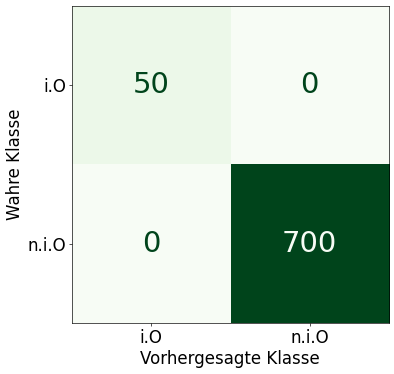

In [29]:
ch.plot_calc_cm(y_test0, y_pred0, class_name=["i.O", "n.i.O"], dpi=60)

In [32]:
params = {'n_estimators':[50, 100, 200], 'criterion':['gini', 'entropy'],
              'min_samples_leaf': [1,4,8], 'min_samples_split': [2,4,8],
              'max_depth':[20,80,200], 'max_features':['sqrt', 'log2'],
              'min_impurity_decrease':[0.0, 0.0001, 0.001]}
params

{'n_estimators': [50, 100, 200],
 'criterion': ['gini', 'entropy'],
 'min_samples_leaf': [1, 4, 8],
 'min_samples_split': [2, 4, 8],
 'max_depth': [20, 80, 200],
 'max_features': ['sqrt', 'log2'],
 'min_impurity_decrease': [0.0, 0.0001, 0.001]}

In [33]:
best_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 80,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [34]:
res = ch.collect_results_mlc(y_test, y_pred, algorithm="randomforest", params=params, best_param=best_clf.get_params())
res

{'algorithm': 'randomforest',
 'params': {'n_estimators': [50, 100, 200],
  'criterion': ['gini', 'entropy'],
  'min_samples_leaf': [1, 4, 8],
  'min_samples_split': [2, 4, 8],
  'max_depth': [20, 80, 200],
  'max_features': ['sqrt', 'log2'],
  'min_impurity_decrease': [0.0, 0.0001, 0.001]},
 'best_param': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'entropy',
  'max_depth': 80,
  'max_features': 'sqrt',
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 4,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 200,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False},
 'rec_0': 1.0,
 'pre_0': 1.0,
 'f1_0': 1.0,
 'rec_weighted': 0.9291666666666667,
 'pre_weighted': 0.9769055869412053,
 'f1_weighted': 0.9514424209820369,
 'acc': 0.8973333333333333}

In [35]:
#ch.save_results_json(filename="mlc_algorithm_adaption_hyperopt_results_v2.4.json", 
                     key_algorithm = "rf", 
                     hyperopt_result = res)

existing file mlc_algorithm_adaption_hyperopt_results_v2.4.json opened and results of rf saved.
